In [1]:
# ===========================
# BLAS / LAPACK thread control
# ===========================
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

from LOD import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy import sparse
import scipy.linalg as la
import scipy.sparse.linalg as spla

In [2]:
# mesh parameters
H = 2**(-3)
h = 2**(-7)

Nx = int(1 / H)
Ny = Nx
refine = int(H / h)

mesh = build_triangular_mesh(Nx, Ny, refine)

coarse_nodes = mesh["coarse_nodes"]
fine_nodes   = mesh["fine_nodes"]
coarse_elems = mesh["coarse_elems"]
fine_elems   = mesh["fine_elems"]

N_H = coarse_nodes.shape[0]
N_h = fine_nodes.shape[0]

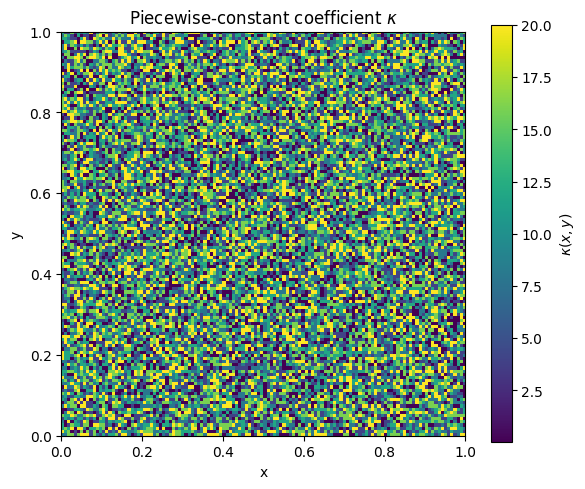

In [3]:
epsi = 0.01
kappa_values = np.array([epsi, 4.0, 8.0, 12.0, 16.0, 20.0])

matrix = np.zeros((int(1/h), int(1/h)))

rng = np.random.default_rng()
for j in range(int(1/h)):
    for i in range(int(1/h)):
        idx = rng.integers(0, len(kappa_values))
        matrix[j, i] = kappa_values[idx]

def checkerboard(x, y):
    x = min(max(x, 0.0), 1.0 - 1e-14)
    y = min(max(y, 0.0), 1.0 - 1e-14)

    i = int(x * int(1/h))
    j = int(y * int(1/h))

    return matrix[j, i]

nplot = 128

xs = np.linspace(0.0, 1.0, nplot)
ys = np.linspace(0.0, 1.0, nplot)

plot_matrix = np.zeros((nplot, nplot))

for j, y in enumerate(ys):
    for i, x in enumerate(xs):
        # avoid ambiguity exactly at x=1 or y=1
        xx = min(x, 1.0 - 1e-12)
        yy = min(y, 1.0 - 1e-12)
        plot_matrix[j, i] = checkerboard(xx, yy)   # make_fast_kappa_uniform result

plt.figure(figsize=(6, 5))
plt.imshow(
    plot_matrix,
    origin="lower",
    extent=(0, 1, 0, 1),
    cmap="viridis",
    interpolation="nearest",
    aspect="equal"
)
plt.colorbar(label=r"$\kappa(x,y)$")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Piecewise-constant coefficient $\\kappa$")
plt.tight_layout()
plt.show()

In [4]:
rough_coeff = lambda x,y: checkerboard(x,y)

print("Assemble Stiffness Matrix...")
A_dc, M_dc, sigma = build_fine_element_matrices(mesh, rough_coeff, n_jobs=-1)

print("Assemble global...")
A_h, M_h = assemble_global_from_Adc_Mdc(A_dc, M_dc, sigma, N_h)

print("Assemble load vec...")
# load vector f ≡ 1
f_h = assemble_load_tri(
    fine_nodes, fine_elems, lambda x, y: 1.0
)

# interpolation and boundary matrices
print("Assemble interpolation matrix...")
P_h = build_P_triangular(mesh)
print("Assemble B_H")
B_H = build_B_H(coarse_nodes, Nx, Ny)

Assemble Stiffness Matrix...
Assemble global...
Assemble load vec...
Assemble interpolation matrix...
Assemble B_H


In [5]:
adjacency = build_coarse_adjacency_edge(coarse_elems)
fine_in_coarse = precompute_fine_in_coarse(mesh)

In [6]:
C_h = build_IH_quasi_interpolation(mesh)

In [7]:
k=5
Q_h = computeCorrections(mesh, k, adjacency, fine_in_coarse, A_h, B_H, C_h, rough_coeff, n_jobs=-1)

In [9]:
u_h_LOD, u_H_LOD = solveLODSystem(
    A_h, f_h, P_h, Q_h, B_H
)

In [10]:
u_h_fine = solve_fine_problem(A_h, f_h, fine_nodes)

In [11]:
def relative_L2_error(u, v, M):
    diff = u - v
    num = diff @ (M @ diff)
    den = v @ (M @ v)
    return np.sqrt(num / den)

err_L2 = relative_L2_error(u_h_LOD, u_h_fine, M_h)
print("Relative L2 error:", err_L2)

Relative L2 error: 0.012154670759140895


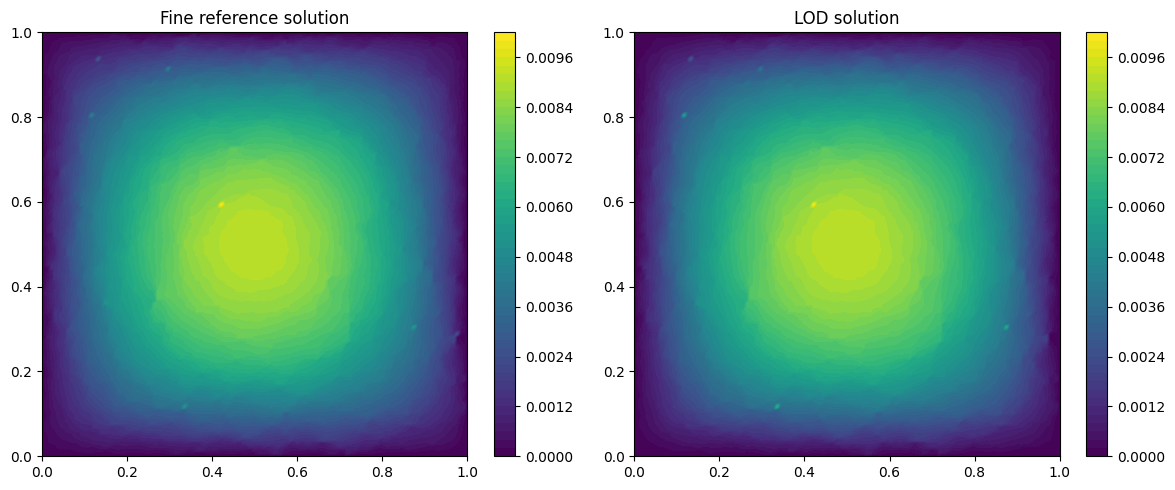

In [12]:
tri = mtri.Triangulation(
    fine_nodes[:,0],
    fine_nodes[:,1],
    fine_elems
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.tricontourf(tri, u_h_fine, levels=50)
plt.colorbar()
plt.title("Fine reference solution")

plt.subplot(1,2,2)
plt.tricontourf(tri, u_h_LOD, levels=50)
plt.colorbar()
plt.title("LOD solution")

plt.tight_layout()
plt.show()